# Lecture 2: Capturing spatial correlations in data

In the previous lecture, we used a simple plain feed-forward NN, which allowed us to obtain quite remarkable results in the MNIST dataset. However, for datasets that involve strong spatial correlations we may need to use more sophisticated methods. In this lecture, we will introduce Convolutional Neural Networks, and also we will briefly discuss regularization techniques. 

In [6]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from tensorflow.keras.optimizers import SGD, Adam
import visualkeras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.datasets import cifar10

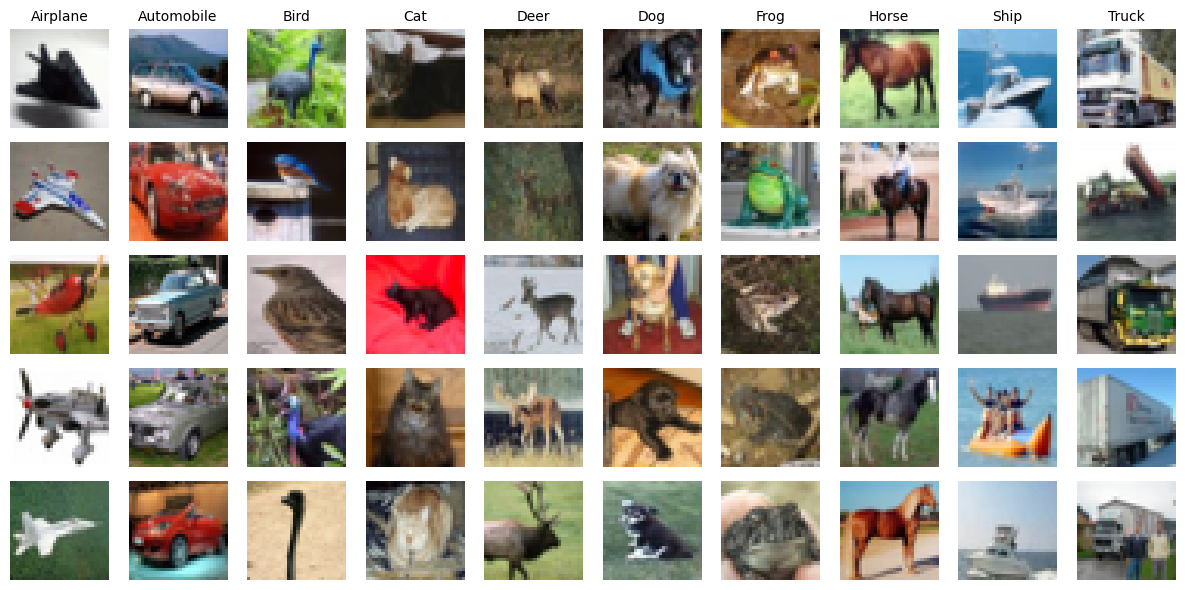

In [11]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Labels for CIFAR-10 classes
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Initialize a figure for the grid
fig, axs = plt.subplots(5, 10, figsize=(12, 6))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# Create a grid with images from each class
for class_idx in range(10):  # Iterate over classes
    class_images = x_train[y_train.flatten() == class_idx]  # Filter images of the current class
    for row in range(5):  # Select 5 images for each class
        img = class_images[row]  # Select the image
        axs[row, class_idx].imshow(img)
        axs[row, class_idx].axis('off')
        if row == 0:  # Add class label as title in the first row
            axs[row, class_idx].set_title(class_labels[class_idx], fontsize=10)

# Show the grid
plt.tight_layout()

plt.show()

In [12]:
print("Load and preprocess the CIFAR-10 dataset")
(X_train_full, y_train_full), (X_test_full, y_test_full) = tf.keras.datasets.cifar10.load_data()
print("done.")

subset_size = 50000
X_train = X_train_full[:subset_size]
y_train = y_train_full[:subset_size]

validation_size = 2000
X_test = X_train_full[subset_size:subset_size + validation_size]
y_test = y_train_full[subset_size:subset_size + validation_size]

# Flatten labels
y_train = y_train.flatten()
y_test = y_test.flatten()

# Flatten input images and convert to float32
X_train = X_train.reshape(-1, 32 * 32 * 3).astype('float32')
X_test = X_test.reshape(-1, 32 * 32 * 3).astype('float32')

# Normalize data to zero mean and unit variance
mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

Load and preprocess the CIFAR-10 dataset
done.


In [13]:
# Split training set into train and validation sets (80%-20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(21, activation='sigmoid', input_shape=(32 * 32 * 3,)),  # Hidden layer with 21 neurons
    Dense(10, activation='softmax')  # Output layer with 10 neurons
])

# Compile the model with SGD optimizer and specified learning rate
eta = 1.0
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with one batch (batch size = training set size)
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=500,
                    batch_size=len(X_train),
                    verbose=2)

Epoch 1/500
1/1 - 1s - 1s/step - accuracy: 0.1270 - loss: 2.4761 - val_accuracy: 0.1751 - val_loss: 2.2577
Epoch 2/500
1/1 - 0s - 468ms/step - accuracy: 0.1783 - loss: 2.2523 - val_accuracy: 0.2199 - val_loss: 2.1522
Epoch 3/500
1/1 - 0s - 498ms/step - accuracy: 0.2222 - loss: 2.1493 - val_accuracy: 0.2653 - val_loss: 2.0848
Epoch 4/500
1/1 - 1s - 513ms/step - accuracy: 0.2659 - loss: 2.0834 - val_accuracy: 0.2802 - val_loss: 2.0410
Epoch 5/500
1/1 - 0s - 490ms/step - accuracy: 0.2863 - loss: 2.0367 - val_accuracy: 0.2924 - val_loss: 2.0159
Epoch 6/500
1/1 - 1s - 578ms/step - accuracy: 0.2973 - loss: 2.0105 - val_accuracy: 0.2980 - val_loss: 2.0061
Epoch 7/500
1/1 - 1s - 622ms/step - accuracy: 0.3049 - loss: 2.0004 - val_accuracy: 0.2826 - val_loss: 2.0079
Epoch 8/500
1/1 - 1s - 611ms/step - accuracy: 0.2907 - loss: 2.0029 - val_accuracy: 0.2932 - val_loss: 1.9865
Epoch 9/500
1/1 - 1s - 566ms/step - accuracy: 0.3021 - loss: 1.9793 - val_accuracy: 0.3035 - val_loss: 1.9629
Epoch 10/500


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


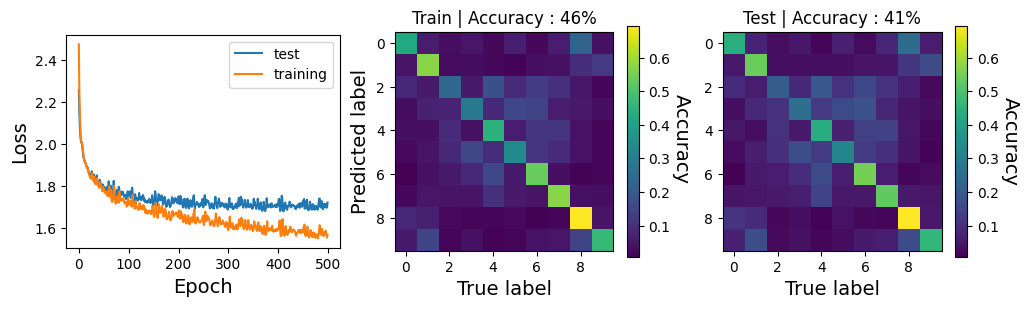

In [14]:
# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)

# Extract loss and accuracy data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = np.array(history.history['accuracy'])
validation_accuracy = np.array(history.history['val_accuracy'])

# Predictions
y_train_pred = np.argmax(model.predict(X_train), axis=1)
y_test_pred = np.argmax(model.predict(X_test), axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

#%%
def get_confusion_matrix(pred, true):
    labels = np.unique(true)
    conf_matrix = np.zeros((len(labels), len(labels)))
    for label in labels:
        idx, counts = np.unique(pred[true == label], return_counts=True)
        idx_ = np.where(idx < 10)
        idx = idx[idx_]
        counts = counts[idx_]
        conf_matrix[label, idx] = counts

    for i in range(conf_matrix.shape[0]):
        total = np.sum(conf_matrix[i, :])
        conf_matrix[i, :] = conf_matrix[i, :] / total if total > 0 else conf_matrix[i, :]
    return conf_matrix

# Confusion matrices
conf_mat_train = get_confusion_matrix(y_train_pred, y_train_true)
conf_mat_test = get_confusion_matrix(y_test_pred, y_test_true)

accuracy_train = np.mean(np.diag(conf_mat_train)) * 100
accuracy_test = np.mean(np.diag(conf_mat_test)) * 100

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
FontSize = 14
ax[0].plot(validation_loss, label='test')
ax[0].plot(training_loss, label='training')
ax[0].set_ylabel('Loss', fontsize=FontSize)
ax[0].set_xlabel("Epoch", fontsize=FontSize)
ax[0].set_aspect(420)
ax[0].legend()

im1 = ax[1].imshow(conf_mat_train, cmap="viridis")
im2 = ax[2].imshow(conf_mat_test, cmap="viridis")
ax[2].set_title("Test | Accuracy : " + "{:2.0f}".format(accuracy_test) + "%")
ax[1].set_title("Train | Accuracy : " + "{:2.0f}".format(accuracy_train) + "%")

ax[1].set_ylabel("Predicted label", fontsize=FontSize)

cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.5)
cbar1.ax.set_ylabel('Accuracy ', rotation=270, labelpad=15, fontsize=FontSize)

cbar2 = fig.colorbar(im1, ax=ax[2], shrink=0.5)
cbar2.ax.set_ylabel('Accuracy', rotation=270, labelpad=15, fontsize=FontSize)

ax[1].set_xlabel("True label", fontsize=FontSize)
ax[2].set_xlabel("True label", fontsize=FontSize)

plt.show()

We see that the performance of our FeedForward NN is very poor. What do we lack in our approach? Capturing spatial correlations! Instead of a FF NN, we will use now a Convolutional NN (see notes).

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [16]:
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize data to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split training set into train and validation sets (80%-20%)
x_train, x_test, y_train, y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

In [19]:
# Define the CNN model
model = Sequential([
    # First convolutional block
    Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    # Fully connected layer
    Flatten(),
    Dense(21, activation='sigmoid'),
    Dense(10, activation='softmax')
])

# Compile the model with SGD optimizer and specified learning rate
eta = 0.1
N_epoch = 100
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=N_epoch,batch_size=64,verbose=2)


c:\Users\pablo\OneDrive\Documentos\Master\Machine Learning\DeepLearning-MQST\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
625/625 - 17s - 27ms/step - accuracy: 0.1008 - loss: 2.3061 - val_accuracy: 0.0973 - val_loss: 2.3035
Epoch 2/100
625/625 - 14s - 22ms/step - accuracy: 0.1260 - loss: 2.2769 - val_accuracy: 0.1719 - val_loss: 2.2004
Epoch 3/100
625/625 - 16s - 26ms/step - accuracy: 0.2048 - loss: 2.1239 - val_accuracy: 0.2435 - val_loss: 2.0417
Epoch 4/100
625/625 - 14s - 23ms/step - accuracy: 0.2751 - loss: 1.9877 - val_accuracy: 0.2961 - val_loss: 1.9602
Epoch 5/100
625/625 - 13s - 21ms/step - accuracy: 0.3293 - loss: 1.8748 - val_accuracy: 0.3247 - val_loss: 1.8821
Epoch 6/100
625/625 - 13s - 20ms/step - accuracy: 0.3562 - loss: 1.8048 - val_accuracy: 0.3441 - val_loss: 1.8043
Epoch 7/100
625/625 - 13s - 21ms/step - accuracy: 0.3774 - loss: 1.7459 - val_accuracy: 0.3873 - val_loss: 1.7168
Epoch 8/100
625/625 - 13s - 21ms/step - accuracy: 0.3963 - loss: 1.7007 - val_accuracy: 0.3832 - val_loss: 1.7224
Epoch 9/100
625/625 - 13s - 20ms/step - accuracy: 0.4078 - loss: 1.6591 - val_accuracy: 

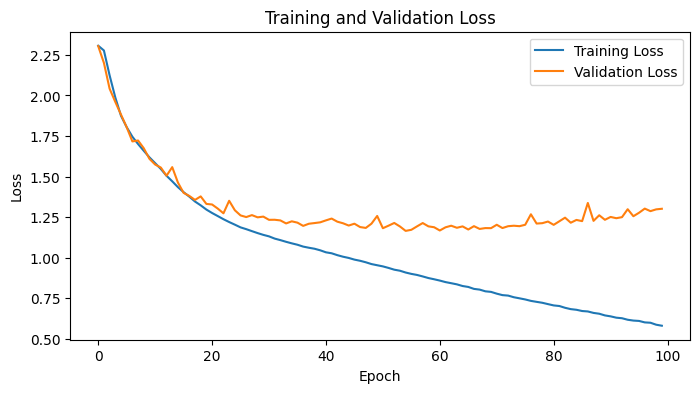

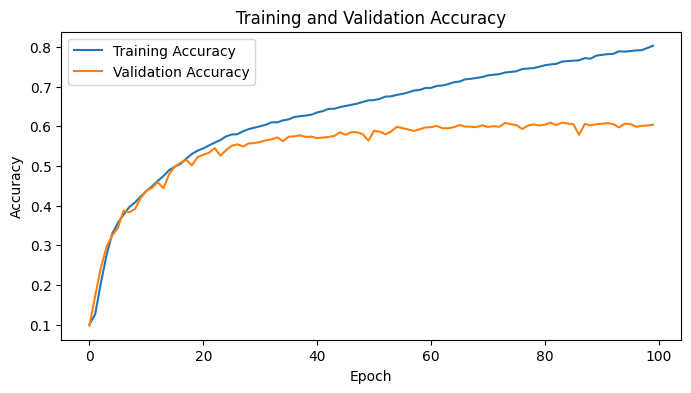

In [20]:
# Evaluate the model
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)

# Extract loss and accuracy data
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = np.array(history.history['accuracy'])
validation_accuracy = np.array(history.history['val_accuracy'])

# Plot training and validation loss
plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [21]:
# Predictions for confusion matrix
y_train_pred = np.argmax(model.predict(x_train), axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

def get_confusion_matrix(pred, true):
    labels = np.unique(true)
    conf_matrix = np.zeros((len(labels), len(labels)))
    for label in labels:
        idx, counts = np.unique(pred[true == label], return_counts=True)
        idx_ = np.where(idx < 10)
        idx = idx[idx_]
        counts = counts[idx_]
        conf_matrix[label, idx] = counts

    for i in range(conf_matrix.shape[0]):
        total = np.sum(conf_matrix[i, :])
        conf_matrix[i, :] = conf_matrix[i, :] / total if total > 0 else conf_matrix[i, :]
    return conf_matrix

# Confusion matrices
conf_mat_train = get_confusion_matrix(y_train_pred, y_train_true)
conf_mat_test = get_confusion_matrix(y_test_pred, y_test_true)

vmin_train = min(conf_mat_train.min(), conf_mat_train.min())
vmax_train = max(conf_mat_train.max(), conf_mat_train.max())
vmin_test = min(conf_mat_test.min(), conf_mat_test.min())
vmax_test = max(conf_mat_test.max(), conf_mat_test.max())

accuracy_train = np.mean(np.diag(conf_mat_train)) * 100
accuracy_test = np.mean(np.diag(conf_mat_test)) * 100

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


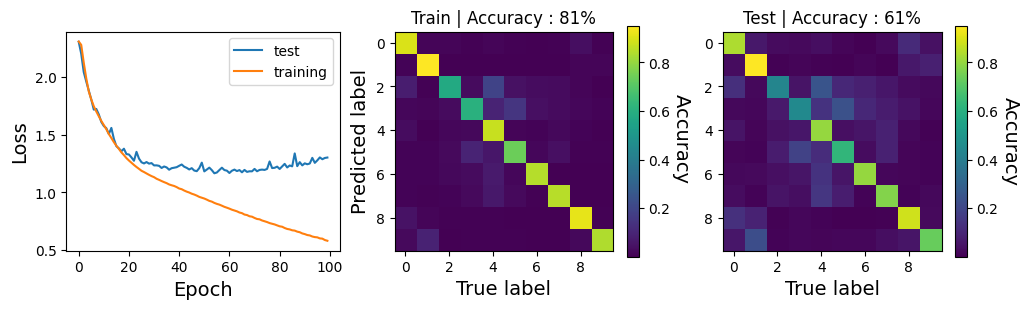

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
FontSize = 14
ax[0].plot(validation_loss, label='test')
ax[0].plot(training_loss, label='training')
ax[0].set_ylabel('Loss', fontsize=FontSize)
ax[0].set_xlabel("Epoch", fontsize=FontSize)
ax[0].set_aspect(46)
ax[0].legend()

im1 = ax[1].imshow(conf_mat_train, cmap="viridis", vmin=vmin_train, vmax=vmax_train)
im2 = ax[2].imshow(conf_mat_test, cmap="viridis", vmin=vmin_test, vmax=vmax_test)
ax[2].set_title("Test | Accuracy : " + "{:2.0f}".format(accuracy_test) + "%")
ax[1].set_title("Train | Accuracy : " + "{:2.0f}".format(accuracy_train) + "%")

ax[1].set_ylabel("Predicted label", fontsize=FontSize)

cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.5)
cbar1.ax.set_ylabel('Accuracy ', rotation=270, labelpad=15, fontsize=FontSize)

cbar2 = fig.colorbar(im1, ax=ax[2], shrink=0.5)
cbar2.ax.set_ylabel('Accuracy', rotation=270, labelpad=15, fontsize=FontSize)

ax[1].set_xlabel("True label", fontsize=FontSize)
ax[2].set_xlabel("True label", fontsize=FontSize)

plt.show()

We already see some improvements: the training accuracy is much better. However, we are still far from an acceptable accuracy, and also we can see that there is a big gap between the test and the training loss. This is always bad news! Let us try with a slightly different architecture, by adding more CNN to our model (see notes).

In [23]:
# Define a new CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

eta = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
N_epoch = 100

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=N_epoch,
                    batch_size=64,
                    verbose=2)

Epoch 1/100
625/625 - 41s - 66ms/step - accuracy: 0.2087 - loss: 2.1744 - val_accuracy: 0.2753 - val_loss: 2.0187
Epoch 2/100
625/625 - 38s - 61ms/step - accuracy: 0.3181 - loss: 1.9205 - val_accuracy: 0.3584 - val_loss: 1.8087
Epoch 3/100
625/625 - 39s - 63ms/step - accuracy: 0.3817 - loss: 1.7449 - val_accuracy: 0.4009 - val_loss: 1.6737
Epoch 4/100
625/625 - 39s - 62ms/step - accuracy: 0.4314 - loss: 1.6053 - val_accuracy: 0.4398 - val_loss: 1.5597
Epoch 5/100
625/625 - 44s - 70ms/step - accuracy: 0.4681 - loss: 1.5008 - val_accuracy: 0.4859 - val_loss: 1.4498
Epoch 6/100
625/625 - 41s - 66ms/step - accuracy: 0.4961 - loss: 1.4249 - val_accuracy: 0.5026 - val_loss: 1.3992
Epoch 7/100
625/625 - 41s - 66ms/step - accuracy: 0.5165 - loss: 1.3686 - val_accuracy: 0.5167 - val_loss: 1.3573
Epoch 8/100
625/625 - 39s - 62ms/step - accuracy: 0.5358 - loss: 1.3141 - val_accuracy: 0.5315 - val_loss: 1.3368
Epoch 9/100
625/625 - 37s - 60ms/step - accuracy: 0.5554 - loss: 1.2660 - val_accuracy: 

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


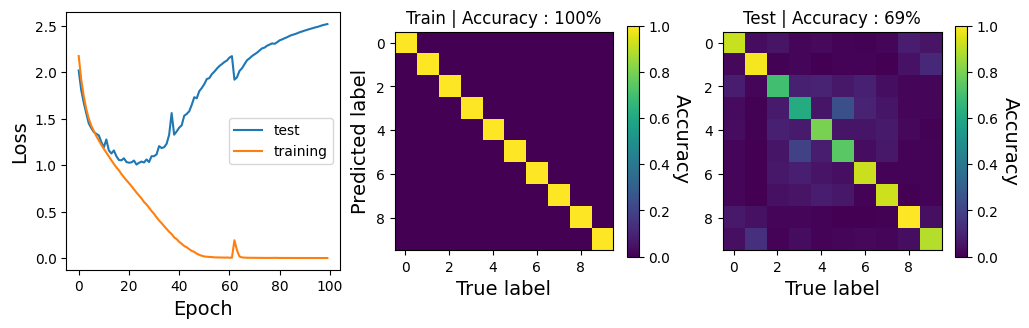

In [25]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = np.array(history.history['accuracy'])
validation_accuracy = np.array(history.history['val_accuracy'])

y_train_pred = np.argmax(model.predict(x_train), axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

def get_confusion_matrix(pred, true):
    labels = np.unique(true)
    conf_matrix = np.zeros((len(labels), len(labels)))
    for label in labels:
        idx, counts = np.unique(pred[true == label], return_counts=True)
        idx_ = np.where(idx < 10)
        idx = idx[idx_]
        counts = counts[idx_]
        conf_matrix[label, idx] = counts

    for i in range(conf_matrix.shape[0]):
        total = np.sum(conf_matrix[i, :])
        conf_matrix[i, :] = conf_matrix[i, :] / total if total > 0 else conf_matrix[i, :]
    return conf_matrix

conf_mat_train = get_confusion_matrix(y_train_pred, y_train_true)
conf_mat_test = get_confusion_matrix(y_test_pred, y_test_true)

vmin_train = min(conf_mat_train.min(), conf_mat_train.min())
vmax_train = max(conf_mat_train.max(), conf_mat_train.max())

vmin_test = min(conf_mat_test.min(), conf_mat_test.min())
vmax_test = max(conf_mat_test.max(), conf_mat_test.max())

accuracy_train = np.mean(np.diag(conf_mat_train)) * 100
accuracy_test = np.mean(np.diag(conf_mat_test)) * 100

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
FontSize = 14
ax[0].plot(validation_loss, label='test')
ax[0].plot(training_loss, label='training')
ax[0].set_ylabel('Loss', fontsize=FontSize)
ax[0].set_xlabel("Epoch", fontsize=FontSize)
ax[0].set_aspect(37)
ax[0].legend()

im1 = ax[1].imshow(conf_mat_train, cmap="viridis", vmin=vmin_train, vmax=vmax_train)
im2 = ax[2].imshow(conf_mat_test, cmap="viridis", vmin=vmin_test, vmax=vmax_test)
ax[2].set_title("Test | Accuracy : " + "{:2.0f}".format(accuracy_test) + "%")
ax[1].set_title("Train | Accuracy : " + "{:2.0f}".format(accuracy_train) + "%")

ax[1].set_ylabel("Predicted label", fontsize=FontSize)

cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.5)
cbar1.ax.set_ylabel('Accuracy ', rotation=270, labelpad=15, fontsize=FontSize)

cbar2 = fig.colorbar(im1, ax=ax[2], shrink=0.5)
cbar2.ax.set_ylabel('Accuracy', rotation=270, labelpad=15, fontsize=FontSize)

ax[1].set_xlabel("True label", fontsize=FontSize)
ax[2].set_xlabel("True label", fontsize=FontSize)

plt.show()

We see that we have a clear case of _overfitting_. The training set is predicted perfectly (100% acc), but we see that the model doesn't generalize well to the testing set; in fact, we only have improved an 8% in acc from the previous model. Looking at the plot of the loss functions for the train and test, we can clearly observe the overfitting in our model. To correct this, we implement _regularization_ techniques. 

Regularization refers to adding contraints to the model's parameters, in order to reduce overfitting. In this lecture, we use the _Dropout_ technique and also _L2 regularization_ (see notes). 

In [27]:
from tensorflow.keras.regularizers import l2

lambda_L2 = 0.01
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3), kernel_regularizer=l2(lambda_L2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(lambda_L2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(lambda_L2)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dropout(0.4),
    Dense(512, activation='relu', kernel_regularizer=l2(lambda_L2)),
    Dense(10, activation='softmax', kernel_regularizer=l2(lambda_L2))
])

eta = 0.01
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

def lr_schedule(epoch):
    return eta * (0.1 ** (epoch // 20))

lr_scheduler = LearningRateScheduler(lr_schedule)

c:\Users\pablo\OneDrive\Documentos\Master\Machine Learning\DeepLearning-MQST\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
N_epoch = 50

history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=N_epoch,
                    batch_size=64,
                    callbacks=[lr_scheduler],
                    verbose=2)

Epoch 1/50
625/625 - 78s - 124ms/step - accuracy: 0.3668 - loss: 10.4587 - val_accuracy: 0.4452 - val_loss: 9.1098 - learning_rate: 0.0100
Epoch 2/50
625/625 - 77s - 123ms/step - accuracy: 0.4870 - loss: 8.1009 - val_accuracy: 0.5518 - val_loss: 7.1586 - learning_rate: 0.0100
Epoch 3/50
625/625 - 76s - 121ms/step - accuracy: 0.5358 - loss: 6.5201 - val_accuracy: 0.5508 - val_loss: 5.8741 - learning_rate: 0.0100
Epoch 4/50
625/625 - 85s - 136ms/step - accuracy: 0.5752 - loss: 5.2860 - val_accuracy: 0.5177 - val_loss: 4.9699 - learning_rate: 0.0100
Epoch 5/50
625/625 - 62s - 99ms/step - accuracy: 0.6034 - loss: 4.3314 - val_accuracy: 0.6135 - val_loss: 3.9343 - learning_rate: 0.0100
Epoch 6/50
625/625 - 62s - 99ms/step - accuracy: 0.6322 - loss: 3.5893 - val_accuracy: 0.4402 - val_loss: 3.8122 - learning_rate: 0.0100
Epoch 7/50
625/625 - 61s - 97ms/step - accuracy: 0.6529 - loss: 3.0096 - val_accuracy: 0.5123 - val_loss: 3.2278 - learning_rate: 0.0100
Epoch 8/50
625/625 - 57s - 92ms/step

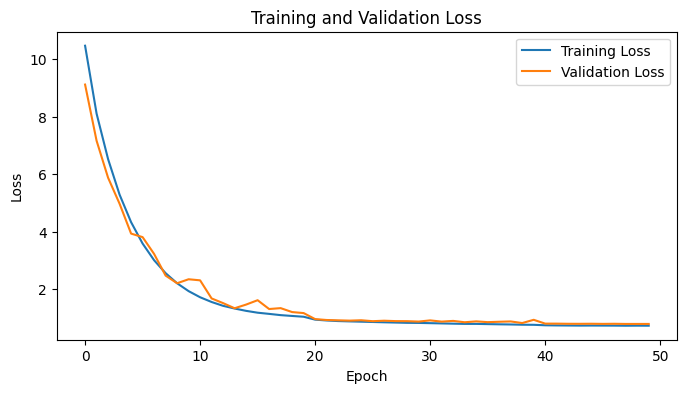

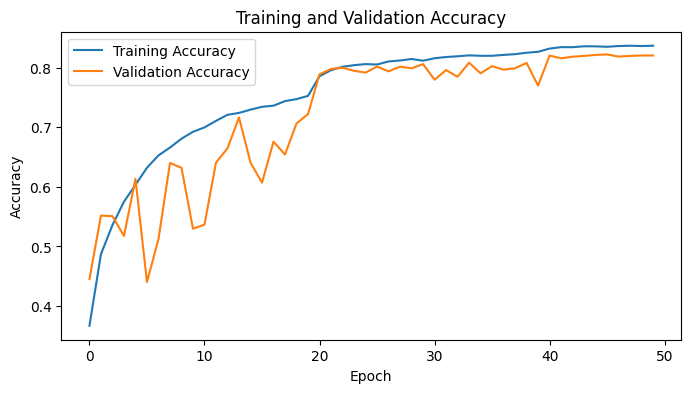

In [33]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)

training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = np.array(history.history['accuracy'])
validation_accuracy = np.array(history.history['val_accuracy'])

plt.figure(figsize=(8, 4))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


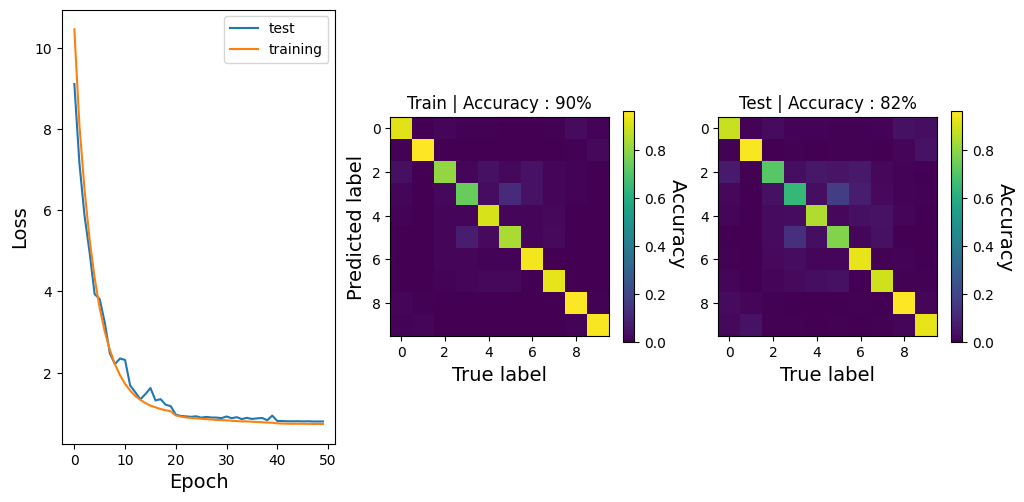

In [34]:
y_train_pred = np.argmax(model.predict(x_train), axis=1)
y_test_pred = np.argmax(model.predict(x_test), axis=1)
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

def get_confusion_matrix(pred, true):
    labels = np.unique(true)
    conf_matrix = np.zeros((len(labels), len(labels)))
    for label in labels:
        idx, counts = np.unique(pred[true == label], return_counts=True)
        idx_ = np.where(idx < 10)
        idx = idx[idx_]
        counts = counts[idx_]
        conf_matrix[label, idx] = counts

    for i in range(conf_matrix.shape[0]):
        total = np.sum(conf_matrix[i, :])
        conf_matrix[i, :] = conf_matrix[i, :] / total if total > 0 else conf_matrix[i, :]
    return conf_matrix

conf_mat_train = get_confusion_matrix(y_train_pred, y_train_true)
conf_mat_test = get_confusion_matrix(y_test_pred, y_test_true)

vmin_train = min(conf_mat_train.min(), conf_mat_train.min())
vmax_train = max(conf_mat_train.max(), conf_mat_train.max())
vmin_test = min(conf_mat_test.min(), conf_mat_test.min())
vmax_test = max(conf_mat_test.max(), conf_mat_test.max())

accuracy_train = np.mean(np.diag(conf_mat_train)) * 100
accuracy_test = np.mean(np.diag(conf_mat_test)) * 100

fig, ax = plt.subplots(1, 3, figsize=(12, 6))
FontSize = 14
ax[0].plot(validation_loss, label='test')
ax[0].plot(training_loss, label='training')
ax[0].set_ylabel('Loss', fontsize=FontSize)
ax[0].set_xlabel("Epoch", fontsize=FontSize)
ax[0].set_aspect(8)
ax[0].legend()

im1 = ax[1].imshow(conf_mat_train, cmap="viridis", vmin=vmin_train, vmax=vmax_train)
im2 = ax[2].imshow(conf_mat_test, cmap="viridis", vmin=vmin_test, vmax=vmax_test)
ax[2].set_title("Test | Accuracy : " + "{:2.0f}".format(accuracy_test) + "%")
ax[1].set_title("Train | Accuracy : " + "{:2.0f}".format(accuracy_train) + "%")

ax[1].set_ylabel("Predicted label", fontsize=FontSize)

cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.5)
cbar1.ax.set_ylabel('Accuracy ', rotation=270, labelpad=15, fontsize=FontSize)

cbar2 = fig.colorbar(im1, ax=ax[2], shrink=0.5)
cbar2.ax.set_ylabel('Accuracy', rotation=270, labelpad=15, fontsize=FontSize)

ax[1].set_xlabel("True label", fontsize=FontSize)
ax[2].set_xlabel("True label", fontsize=FontSize)

plt.show()

With regularization, the model generalizes much better. We lose a little accuracy on the training set, but we gain a lot of accuracy on the testing set (bias/variance tradeoff). Regularization techniques are important to avoid overfitting; we don't want our model to "memorize", but instead to extract patterns!

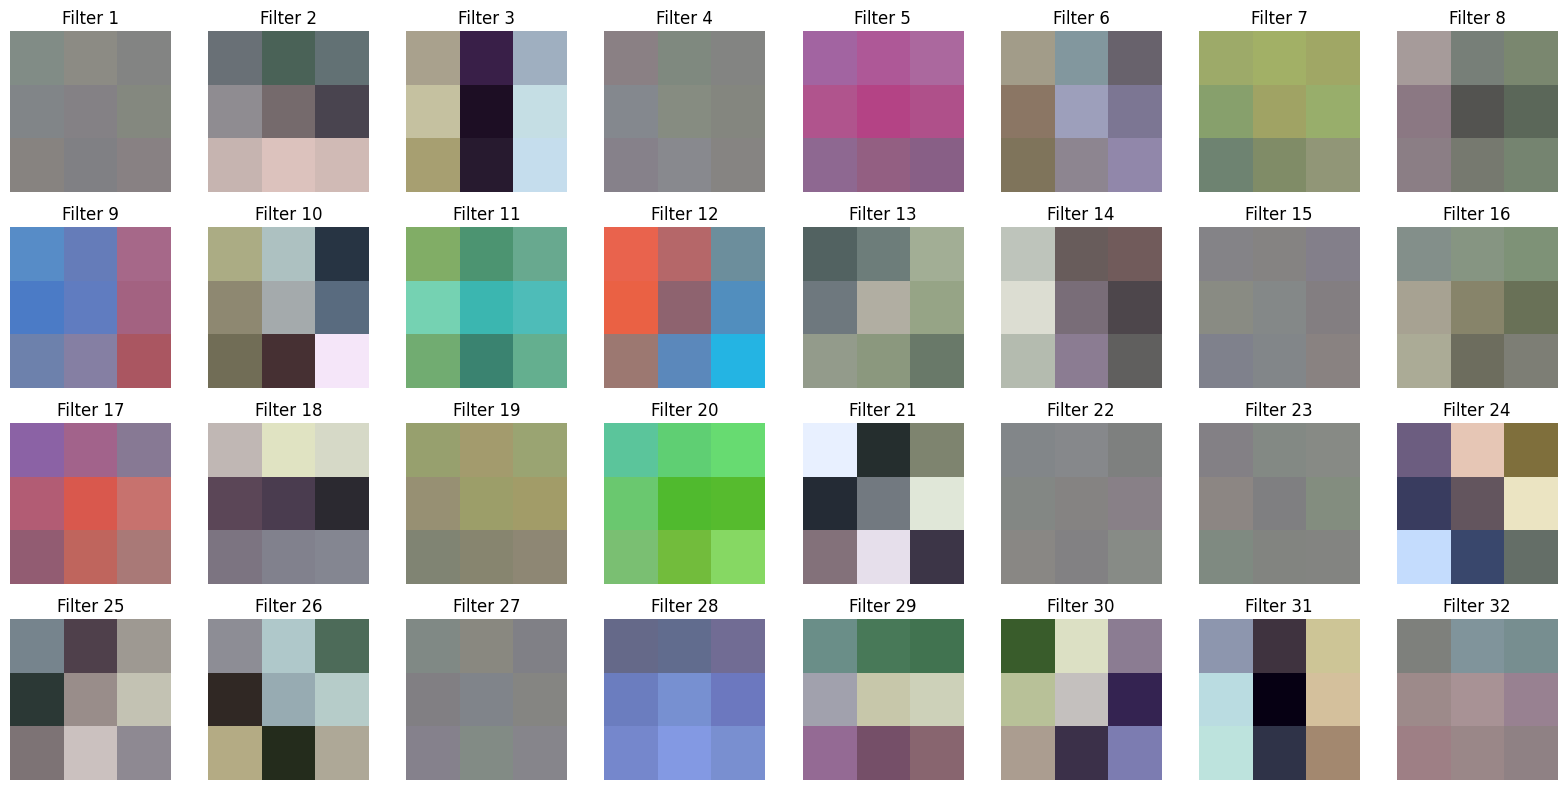

In [35]:
def visualize_first_layer_kernels(model, layer_index=0, num_filters=32, figsize=(16, 8)):
    conv_layer = model.layers[layer_index]
    if not isinstance(conv_layer, Conv2D):
        raise ValueError(f"Layer at index {layer_index} is not a Conv2D layer.")
    filters, biases = conv_layer.get_weights()
    f_min, f_max = filters.min(), filters.max()
    filters_normalized = (filters - f_min) / (f_max - f_min)
    n_columns = 8
    n_rows = num_filters // n_columns
    if num_filters % n_columns != 0:
        n_rows += 1
    plt.figure(figsize=figsize)
    for i in range(num_filters):
        if i >= num_filters:
            break
        ax = plt.subplot(n_rows, n_columns, i + 1)
        f = filters_normalized[:, :, :, i]
        plt.imshow(f, interpolation='nearest')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.tight_layout()
    plt.show()

visualize_first_layer_kernels(model, layer_index=0, num_filters=32, figsize=(16, 8))

This filter shows the process of convolutional NN, applying filters to the data and extracting patterns (see notes).